# Link de tutorial:
https://youtu.be/1uQSpujp74o


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Importar imágenes

In [2]:
from get_images import get_images

In [3]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float32)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float32)
y_test = y_test_num.copy().reshape(10000, 1)

# Normalizaf imágenes

In [4]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [5]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

In [6]:
x_test.shape

(10000, 784)

In [7]:
y_train.shape

(50000, 1)

# Mostrar imágenes

In [8]:
def plot_number(image):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 8


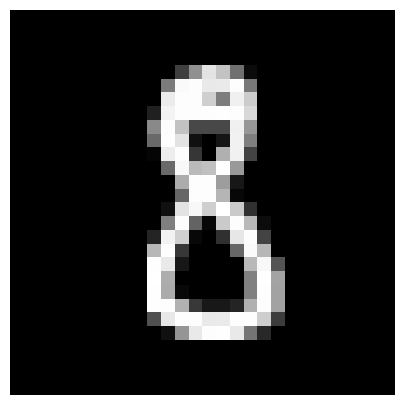

In [9]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx][0]}')
plot_number(x_test_num[rnd_idx])

# Crear minibatches

In [10]:
def create_minibatches(x, y, mb_size, shuffle=True):
    '''
    x  # muestras, 784
    y # muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Convertir Numpy array a PyTorch tensor

In [11]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())

In [12]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Compute accuracy


In [13]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            
            scores = model(xi) # (mb_size, 10)
            pred = scores.argmax(dim=1) # Return de max value and index, this vector return of shape (mb_size).
            num_correct += (pred==yi.squeeze()).sum() # yi have dimention of (batch_size, 1) so squeeze change dimention to  (mb_size).
            num_total += pred.size(0)
        
        return float(num_correct)/num_total
            
            
            
    




In [14]:
x_train_tensor.shape

torch.Size([50000, 784])

# Loop de entrenamiento

In [19]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            
            scores = model(xi)
            
       
            # Funcion cost
            cost = F.cross_entropy(
                input=scores,
                target=yi.squeeze(),
                
            )
            optimizer.zero_grad()
            
            cost.backward()
            optimizer.step()
        
        if epoch%20 == 0:
            print(f'Epoch: {epoch+1}, cost: {cost.item()}, accuracy {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')
        
            
    



# Modelo usando Sequential

In [20]:
# Instanciar model
hidden1 = 200
hidden = 200
out_features = 10
lr = 1e-2
epochs = 20
mb_size = 32
model1 = nn.Sequential(
    nn.Linear(in_features=784, out_features=200),
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=out_features)
    
)

In [21]:

optimizer = torch.optim.SGD(model1.parameters(), lr=lr)

In [22]:

train(model1, optimizer, mb_size, epochs)

Epoch: 1, cost: 0.6280459761619568, accuracy 0.9208


In [23]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.978

La imagen muestreada representa un: 4
Precition: 4


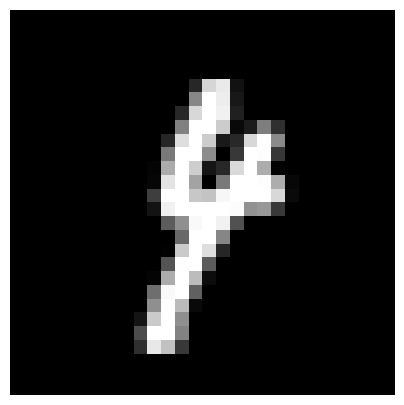

In [35]:
with torch.no_grad():
    rnd_idx = np.random.randint(len(y_train))
    print(f'La imagen muestreada representa un: {y_train[rnd_idx][0]}')
    predict = model1(input=x_train_tensor[rnd_idx,:].float().to(device=device)).argmax()
    print(f'Precition: {predict}')
    plot_number(x_train_num[rnd_idx])
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]
    # print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [40]:
# Instanciar model
hidden1 = 200
hidden = 200
out_features = 10
lr = 1e-2
epochs = 20
mb_size = 32
models = {}
# Buscar en el intervalo [0.001, 1]
for i in range(10):
    print(f"Model {i+1}")
    j = -3*np.random.rand()
    lr = 10**j
    print(f"Modelo con learning reate de: {lr}")
    model1 = nn.Sequential(
        nn.Linear(in_features=784, out_features=200),
        nn.ReLU(),
        nn.Linear(in_features=200, out_features=out_features)

    )
    optimizer = torch.optim.SGD(model1.parameters(), lr=lr)
    train(model1, optimizer, mb_size, epochs)
    acc = accuracy(model1, x_val_tensor, y_val_tensor, mb_size)
    print(f'La precisión final es de: {acc}')
    print()
    models[f"{lr}"] = acc

Model 1
Modelo con learning reate de: 0.5851913211122822
Epoch: 1, cost: 0.7129595875740051, accuracy 0.8774
La precisión final es de: 0.9518

Model 2
Modelo con learning reate de: 0.2820809076510682
Epoch: 1, cost: 0.040236640721559525, accuracy 0.9579
La precisión final es de: 0.9761

Model 3
Modelo con learning reate de: 0.17190684844108814
Epoch: 1, cost: 0.030286692082881927, accuracy 0.9639
La precisión final es de: 0.9829

Model 4
Modelo con learning reate de: 0.5144335179330216
Epoch: 1, cost: 1.072703242301941, accuracy 0.8645
La precisión final es de: 0.957

Model 5
Modelo con learning reate de: 0.0010307042821180736
Epoch: 1, cost: 0.6068402528762817, accuracy 0.8616
La precisión final es de: 0.9423

Model 6
Modelo con learning reate de: 0.0020023027844560323
Epoch: 1, cost: 0.3588758111000061, accuracy 0.8908
La precisión final es de: 0.9587

Model 7
Modelo con learning reate de: 0.0027139203334523776
Epoch: 1, cost: 0.3384550213813782, accuracy 0.8992
La precisión final es

In [41]:
for key, value in models.items():
    print(f"Learning rate de: {key}\nPrecisión de: {value}")

Learning rate de: 0.5851913211122822
Precisión de: 0.9518
Learning rate de: 0.2820809076510682
Precisión de: 0.9761
Learning rate de: 0.17190684844108814
Precisión de: 0.9829
Learning rate de: 0.5144335179330216
Precisión de: 0.957
Learning rate de: 0.0010307042821180736
Precisión de: 0.9423
Learning rate de: 0.0020023027844560323
Precisión de: 0.9587
Learning rate de: 0.0027139203334523776
Precisión de: 0.9645
Learning rate de: 0.05330472850599133
Precisión de: 0.9821
Learning rate de: 0.019287873538997184
Precisión de: 0.9799
Learning rate de: 0.003010013386961575
Precisión de: 0.9661


In [43]:
models_ord = sorted(models.items(), key=lambda x: x[1], reverse=True)

In [44]:
models_ord

[('0.17190684844108814', 0.9829),
 ('0.05330472850599133', 0.9821),
 ('0.019287873538997184', 0.9799),
 ('0.2820809076510682', 0.9761),
 ('0.003010013386961575', 0.9661),
 ('0.0027139203334523776', 0.9645),
 ('0.0020023027844560323', 0.9587),
 ('0.5144335179330216', 0.957),
 ('0.5851913211122822', 0.9518),
 ('0.0010307042821180736', 0.9423)]

In [48]:
19/1000, 171/1000

(0.019, 0.17)

In [62]:
random.randrange(19, 171) / 1000

0.024

In [50]:
import random

In [63]:
# Instanciar model
hidden1 = 200
hidden = 200
out_features = 10
lr = 1e-2
epochs = 20
mb_size = 32
models = {}
# Buscar en el intervalo [0.001, 1]
for i in range(10):
    print(f"Model {i+1}")
    lr = random.randrange(19, 171) / 1000
    print(f"Modelo con learning reate de: {lr}")
    model1 = nn.Sequential(
        nn.Linear(in_features=784, out_features=200),
        nn.ReLU(),
        nn.Linear(in_features=200, out_features=out_features)

    )
    optimizer = torch.optim.SGD(model1.parameters(), lr=lr)
    train(model1, optimizer, mb_size, epochs)
    acc = accuracy(model1, x_val_tensor, y_val_tensor, mb_size)
    print(f'La precisión final es de: {acc}')
    print()
    models[f"{lr}"] = acc

Model 1
Modelo con learning reate de: 0.132
Epoch: 1, cost: 0.07167399674654007, accuracy 0.9672
La precisión final es de: 0.9825

Model 2
Modelo con learning reate de: 0.087
Epoch: 1, cost: 0.35433849692344666, accuracy 0.9518
La precisión final es de: 0.9833

Model 3
Modelo con learning reate de: 0.142
Epoch: 1, cost: 0.013729695230722427, accuracy 0.9638
La precisión final es de: 0.9837

Model 4
Modelo con learning reate de: 0.153
Epoch: 1, cost: 0.20779722929000854, accuracy 0.9658
La precisión final es de: 0.9845

Model 5
Modelo con learning reate de: 0.059
Epoch: 1, cost: 0.06828097999095917, accuracy 0.966
La precisión final es de: 0.9825

Model 6
Modelo con learning reate de: 0.064
Epoch: 1, cost: 0.17789070308208466, accuracy 0.9623
La precisión final es de: 0.9816

Model 7
Modelo con learning reate de: 0.07
Epoch: 1, cost: 0.021566960960626602, accuracy 0.9635
La precisión final es de: 0.9821

Model 8
Modelo con learning reate de: 0.165
Epoch: 1, cost: 0.056498847901821136, a

In [64]:
models_ord = sorted(models.items(), key=lambda x: x[1], reverse=True)
models_ord

[('0.153', 0.9845),
 ('0.142', 0.9837),
 ('0.087', 0.9833),
 ('0.165', 0.9831),
 ('0.081', 0.9827),
 ('0.132', 0.9825),
 ('0.059', 0.9825),
 ('0.047', 0.9823),
 ('0.07', 0.9821),
 ('0.064', 0.9816)]

In [66]:
# Instanciar model
hidden1 = 200
hidden = 200
out_features = 10
lr = 0.153
epochs = 100
mb_size = 32
model1 = nn.Sequential(
    nn.Linear(in_features=784, out_features=200),
    nn.ReLU(),
    nn.Linear(in_features=200, out_features=out_features)
    
)
optimizer = torch.optim.SGD(model1.parameters(), lr=lr)
train(model1, optimizer, mb_size, epochs)

Epoch: 1, cost: 0.15389928221702576, accuracy 0.9609
Epoch: 21, cost: 0.00022917635214980692, accuracy 0.983
Epoch: 41, cost: 1.9221748516429216e-05, accuracy 0.9829
Epoch: 61, cost: 9.658708586357534e-05, accuracy 0.9826
Epoch: 81, cost: 8.68597489898093e-05, accuracy 0.9828


In [67]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.982

La imagen muestreada representa un: 1
Prediction: 1


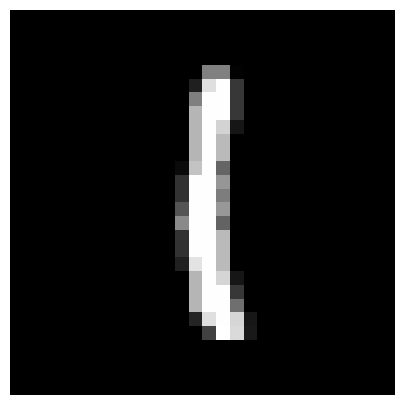

In [217]:
with torch.no_grad():
    rnd_idx = np.random.randint(len(y_train))
    print(f'La imagen muestreada representa un: {y_train[rnd_idx][0]}')
    predict = model1(input=x_train_tensor[rnd_idx,:].float().to(device=device)).argmax()
    print(f'Prediction: {predict}')
    plot_number(x_train_num[rnd_idx])
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]
    # print(f'Predicted: "{predicted}", Actual: "{actual}"')

# Saving model

In [218]:
model_path = './saved_models/modelMNIST.pth'
torch.save(model1.state_dict(), model_path)


In [219]:
model1.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0123, -0.0196,  0.0035,  ...,  0.0138,  0.0227,  0.0095],
                      [ 0.0068, -0.0063,  0.0012,  ..., -0.0265,  0.0116,  0.0096],
                      [ 0.0293, -0.0201,  0.0021,  ...,  0.0389,  0.0089, -0.0282],
                      ...,
                      [ 0.0126,  0.0297, -0.0237,  ..., -0.0178, -0.0205, -0.0303],
                      [-0.0061, -0.0250, -0.0261,  ...,  0.0097, -0.0226,  0.0162],
                      [-0.0152,  0.0317,  0.0095,  ..., -0.0095, -0.0223,  0.0407]],
                     device='cuda:0')),
             ('0.bias',
              tensor([-0.0296,  0.0161, -0.0332, -0.0508,  0.0275,  0.0160,  0.0468,  0.0033,
                       0.0094, -0.0602, -0.0249, -0.0454, -0.0092, -0.0372,  0.0132,  0.0227,
                      -0.0428, -0.0018,  0.0114,  0.0223, -0.0786,  0.0338, -0.0243,  0.0033,
                       0.0162,  0.0191, -0.0020, -0.0208, -0.0126, -0.0092, -0.0128, -0.0179,
  